# In this notebook we will train a quantum circuit (or Born machine) to fit an integer dataset

The dataset in question is 482 measurements of Hidalgo stamps from 1872 [Izenman and Sommer 1988](https://www.jstor.org/stable/2290118#metadata_info_tab_contents), which are integers on the micrometre scale. The data is stored in the `hidalgo_stamp.txt` file in this directory.

More information can be found in [Duffield et al 2022](https://arxiv.org/abs/2206.07559).

In [1]:
from jax import numpy as jnp, random, vmap, value_and_grad, jit
import matplotlib.pyplot as plt

import qujax

In [2]:
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
beta = 1e3
get_stepsize = lambda step: (step + 10) ** (-1/3)
n_steps = 500
random_key = random.PRNGKey(0)

In [3]:
init_key, train_key = random.split(random_key)

# Let's load the data

In [4]:
with open('hidalgo_stamp.txt', "r") as f:
        all_lines = [line[:-1].rstrip().split(' ') for line in f if line != '\n']
data = jnp.hstack([[float(a) for a in line] for line in all_lines]) * 1000
data = jnp.array(data, dtype=int)

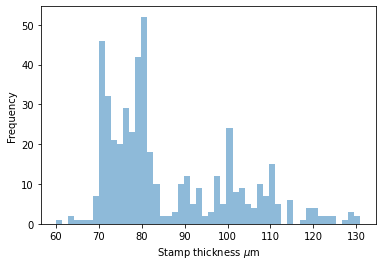

In [5]:
plt.hist(data, bins=50, alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('Stamp thickness $\\mu$m');

# We will use the maximum mean discrepancy (MMD) as our training metric

We attempt to minimise
$$
    \text{MMD}(p, q) = \mathbb{E}_{pp}[k(x,y)] - 2\mathbb{E}_{pq}[k(x,y)] + \mathbb{E}_{qq}[k(x,y)]
$$
where $p$ is the distribution over the output of the quantum circuit (statetensor) and $q$ is the target distribution (which cannot contain zeroes).

In [6]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()

In [7]:
def mmd(kernel, data1, weights1, data2, weights2):
    return expected_kernel(kernel, data1, weights1, data1, weights1) \
           - 2 * expected_kernel(kernel, data1, weights1, data2, weights2) \
           + expected_kernel(kernel, data2, weights2, data2, weights2)

# Now we can use `qujax` to generate a parameter to MMD function

First the quantum circuit (in the form of a parameter to statetensor function)

In [8]:
def get_circuit(n_qubits, depth):
    
    n_params = 2 * n_qubits * (depth + 1)
    
    
    gates = ['H'] * n_qubits + ['Rx'] * n_qubits + ['Ry'] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]
    
    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append('CZ')
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append('Rx')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append('Ry')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

In [9]:
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)

In [10]:
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=48);

q0: -----H-----Rx[0]---Ry[8]-----◯---------------------------------------------Rx[16]--Ry[24]------------◯-----------
                                 |                                                                       |           
q1: -----H-----Rx[1]---Ry[9]-----CZ------◯-------------------------------------Rx[17]--Ry[25]------------CZ------◯---
                                         |                                                                       |   
q2: -----H-----Rx[2]---Ry[10]------------CZ------◯-----------------------------Rx[18]--Ry[26]--------------------CZ--
                                                 |                                                                   
q3: -----H-----Rx[3]---Ry[11]--------------------CZ------◯---------------------Rx[19]--Ry[27]------------------------
                                                         |                                                           
q4: -----H-----Rx[4]---Ry[12]---------------------------

In [11]:
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)

MMD needs a kernel. We'll use a (discrete) Gaussian kernel with the bandwidth chosen with the median heuristic

In [12]:
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
bandwidth_sq = jnp.median(dist_mat) / 2


def gaussian_kernel(s1, s2):
    return jnp.exp(- jnp.square(s1 - s2) / bandwidth_sq)

Now we generate a parameter to MMD function. 

In [13]:
data_probs = jnp.ones(len(data)) / len(data)

def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

# We will use Bayesian learning (SGLD) for training

We'll set a uniform prior and then SGLD will generate samples from the posterior

In [14]:
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

In [15]:
init_param = random.uniform(init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad)

In [16]:
train_keys = random.split(train_key, n_steps - 1)

In [17]:
params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

for step in range(1, n_steps):
    cost_val, cost_grad = param_to_mmd_and_grad(params[step - 1])
    cost_vals = cost_vals.at[step - 1].set(cost_val)
    
    stepsize = get_stepsize(step)

    new_param = params[step - 1] - stepsize * cost_grad\
            + jnp.sqrt(2 * stepsize / beta) * random.normal(train_keys[step - 1], shape=(n_params,))
    params = params.at[step].set(new_param)

    print('Iteration:', step, '\tCost:', cost_val, end='\r')

(0.0, 0.1)

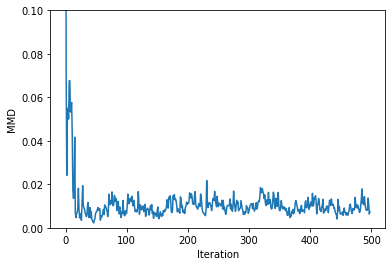

In [18]:
plt.plot(cost_vals)
plt.xlabel('Iteration')
plt.ylabel('MMD')
plt.ylim(0, 0.1)

Trains nicely! The most obvious thing is to just use the parameters from the final iteration, i.e. a point esimate

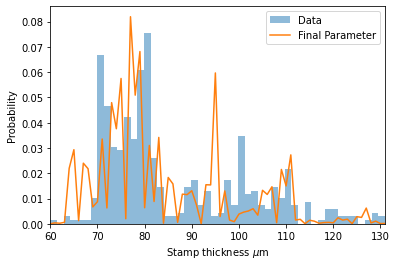

In [19]:
final_params = params[-1]
final_st = param_to_st(final_params)

plt.hist(data, bins=50, density=True, alpha=0.5, label='Data');
plt.plot(jnp.square(jnp.abs(final_st.flatten())), label='Final Parameter')
plt.xlim(data.min(), data.max())
plt.ylabel('Probability')
plt.xlabel('Stamp thickness $\\mu$m')
plt.legend();

However, the Bayesian paradigm dictates that we should integrate over the posterior distribution i.e. average over samples along the trajectory

In [20]:
burn_in = 100
av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:]).mean(0)

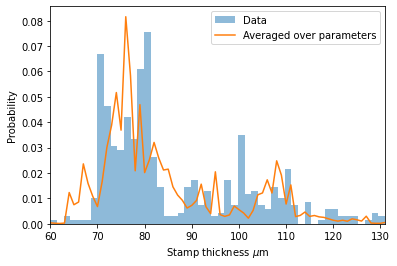

In [21]:
plt.hist(data, bins=50, density=True, alpha=0.5, label='Data');
plt.plot(av_probs, label='Averaged over parameters')
plt.xlim(data.min(), data.max())
plt.ylabel('Probability')
plt.xlabel('Stamp thickness $\\mu$m')
plt.legend();

Observe the generalisation (smoothing) gained from averaging over the parameter trajectory (posterior samples) rather than using the single point estimate